In [24]:
import sys
sys.path.append('../')

import thermonets as tn
import numpy as np
import heyoka as hy
import pykep as pk
import pygmo as pg

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let us open the database and shuffle it

In [46]:
# day, month, year, hour, minute, second, microsecond, [7] alt [km], lat [deg], lon [deg], [10] f107A, f107, [12] ap, [13] density [kg/m^3]
db = np.loadtxt("../dbs/nrlmsise00_db.txt", skiprows=1, delimiter=",")
np.random.shuffle(db)

In [47]:
db_size = db.shape[0]
minh = np.min(db[:, 7])
maxh = np.max(db[:, 7])
print(f"db size is: {db_size}")
print(f"Altitude range is: {minh:.3f} - {maxh:.3f}")
print(f"Ad range is: {np.min(db[:, 12]):.3f} - { np.max(db[:, 12]):.3f}")
print(f"F107 range is: {np.min(db[:, 11]):.3f} - { np.max(db[:, 11]):.3f}")
print(f"density range is: {np.min(db[:, -1]):.3e} - { np.max(db[:, -1]):.3e}")

db size is: 999700
Altitude range is: 180.000 - 1000.000
Ad range is: 0.000 - 106.000
F107 range is: 64.000 - 262.000
density range is: 1.969e-16 - 7.206e-10


we plot some data from the database to check visually all is good:

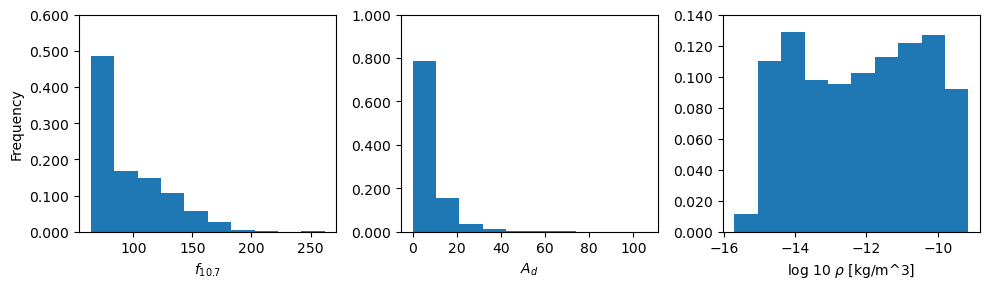

In [48]:
fig, ax = plt.subplots(1,3, figsize=(10,3))

#
ax[0].hist(db[:, 11])
ax[0].set_xlabel("$f_{10.7}$")
ax[0].set_ylabel("Frequency")
yticks = ax[0].get_yticks()
ax[0].set_yticks(yticks)
ax[0].set_yticklabels([f"{it/db_size:.3f}" for it in yticks])

#
ax[1].hist(db[:, 12])
ax[1].set_xlabel("$A_d$")
yticks = ax[1].get_yticks()
ax[1].set_yticks(yticks)
ax[1].set_yticklabels([f"{it/db_size:.3f}" for it in yticks])

#
ax[2].hist(np.log10(db[:, 13]))
ax[2].set_xlabel("log 10 $\\rho$ [kg/m^3]")
yticks = ax[2].get_yticks()
ax[2].set_yticks(yticks)
ax[2].set_yticklabels([f"{it/db_size:.3f}" for it in yticks])

plt.tight_layout()

Now we learn a global fit.

In [49]:
udp = tn.global_fit_udp(db[::100, 7], db[::100,13], n=4)
prob = pg.problem(udp)
uda = pg.sade(10, memory=True, )
algo = pg.algorithm(uda)
pop  =pg.population(prob, 30)

In [59]:
for i in range(20):
    pop = algo.evolve(pop)
    print(f"at iter {i} - {pop.champion_f[0]:.6f}", end = "\r")
best_fit_x = pop.champion_x

We now have a look at the best fit

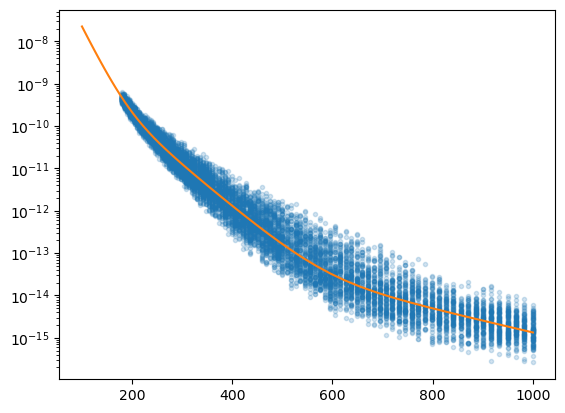

In [72]:
alts = np.logspace(2,3)
plt.semilogy(db[::100,7], db[::100,13], '.', alpha=0.2)
plt.semilogy(alts, tn.rho_approximation(alts, best_fit_x))